In [ ]:
!pip install --upgrade pip
!pip install "tensorflow[and-cuda]"
!pip install pandas


In [1]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

2024-07-28 19:33:05.049203: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-28 19:33:05.137296: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-28 19:33:05.164178: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-28 19:33:05.341278: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-28 19:33:06.331890: W tensorflow/compiler/tf2

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


I0000 00:00:1722209587.422146   63679 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1722209587.591716   63679 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1722209587.591890   63679 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [2]:
BATCH_SIZE = 32
EPOCHS = 100
IMAGE_SIZE = 100

In [3]:

def remove_numbers(s):
    return s.translate(str.maketrans('', '', string.digits))

In [4]:
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import os 
from PIL import Image
import string


# Sao 31 imagens diferentes onde cada uma representa um canal de cor
def load_multispectral_imagem(image_dir):
    file_names = sorted(os.listdir(image_dir))
    qtd_graos = int(len(file_names)/31)
    print(f'Quantidade de graos: {qtd_graos}')

    multispectral_imgs = []

    for i in range(qtd_graos):
        images = [np.array(Image.open(os.path.join(image_dir, file))) for file in file_names[i*31:(i+1)*31]]
        multispectral_img = np.stack(images, axis=-1)   
        multispectral_imgs.append(multispectral_img)    

    return multispectral_imgs

In [5]:
def process_path(image_dir, label):
    images = load_multispectral_imagem(image_dir)
    labels = [label]*len(images)
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    dataset = dataset.map(lambda x, y: (tf.cast(x, tf.uint8), tf.cast(y, tf.int32)))
    dataset = dataset.batch(BATCH_SIZE)
    return dataset

In [6]:
folder_to_label = {}
id_to_label = {}

folders = sorted(os.listdir('_recortado'))

i = -1
for folder in folders:
    keys = list(map(lambda x: remove_numbers(x), folder_to_label.keys()))
    if not remove_numbers(folder) in keys:
        i += 1
        folder_to_label[folder] = i
    else:
        folder_to_label[folder] = i

for key, value in folder_to_label.items():
    id_to_label[value] = remove_numbers(key)

print(folder_to_label)
print(id_to_label)
    
 

{'bandinhas1': 0, 'bandinhas2': 0, 'bandinhas3': 0, 'bandinhas4': 0, 'bandinhas5': 0, 'fermentados1': 1, 'fermentados2': 1, 'fermentados3': 1, 'fermentados4': 1, 'fermentados5': 1, 'mofados1': 2, 'mofados2': 2, 'mofados3': 2, 'mofados4': 2, 'mofados5': 2, 'queimados1': 3, 'queimados2': 3, 'queimados3': 3, 'queimados4': 3, 'queimados5': 3, 'soja1': 4, 'soja2': 4, 'soja3': 4, 'soja4': 4, 'soja5': 4}
{0: 'bandinhas', 1: 'fermentados', 2: 'mofados', 3: 'queimados', 4: 'soja'}


In [7]:
# Enumerate retona um objeto iterável que gera uma tupla contendo um contador e os valores obtidos a partir de um iterável

def create_dataset(base_dir, folder_to_label):
    all_datasets = []

    for folder_name, label in folder_to_label.items():
        class_dir = os.path.join(base_dir, folder_name)
        dataset = process_path(class_dir, label)
        all_datasets.append(dataset)
    
    dataset = all_datasets[0]
    for ds in all_datasets[1:]:
        dataset = dataset.concatenate(ds)

    return dataset
    
dataset = create_dataset('_recortado', folder_to_label=folder_to_label)

Quantidade de graos: 158


I0000 00:00:1722209596.536638   63679 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1722209596.536808   63679 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1722209596.536931   63679 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1722209596.602525   63679 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Quantidade de graos: 145
Quantidade de graos: 160
Quantidade de graos: 160
Quantidade de graos: 217
Quantidade de graos: 92
Quantidade de graos: 112
Quantidade de graos: 116
Quantidade de graos: 142
Quantidade de graos: 112
Quantidade de graos: 56
Quantidade de graos: 55
Quantidade de graos: 56
Quantidade de graos: 53
Quantidade de graos: 55
Quantidade de graos: 128
Quantidade de graos: 119
Quantidade de graos: 127
Quantidade de graos: 123
Quantidade de graos: 116
Quantidade de graos: 265
Quantidade de graos: 143
Quantidade de graos: 120
Quantidade de graos: 185
Quantidade de graos: 111


In [8]:
len(dataset)


105

In [9]:
def preview_dataset(dataset):    
    batch_count = 0
    for images_batch, labels_batch in dataset:
        print(f'Batch de imagens shape: {images_batch.shape}')
        print(f'Batch de labels shape: {labels_batch.shape}')
        
        for image, label in zip(images_batch, labels_batch):
            qtd_canais = image.shape[-1]

            print(image.shape)    
            print(id_to_label[label.numpy() ])

            plt.figure(figsize=(64,64))
            for i in range(qtd_canais):
                image_to_show = image[..., i]
                plt.subplot(1,31,i+1)
                plt.imshow(image_to_show)
                plt.axis('off')
            plt.show()

#preview_dataset(dataset)

In [10]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    total_size = len(ds)
    train_size = int(total_size * train_split)
    validation_size = int(total_size * val_split)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_ds = ds.take(train_size)
    remaining_ds = ds.skip(train_size)

    val_ds = remaining_ds.take(validation_size)
    test_ds = remaining_ds.skip(validation_size)
    return train_ds, val_ds, test_ds

In [11]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

print(f'Quantidade de imagens de treino: {len(train_ds)}')
print(f'Quantidade de imagens de validação: {len(val_ds)}')
print(f'Quantidade de imagens de teste: {len(test_ds)}')

# Cache: Mantém as imagens na memória após serem carregadas do disco
# Shuffle: Mistura as imagens de treino
# Prefetch: Carrega as imagens para a GPU enquanto a GPU está ocupada
train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Quantidade de imagens de treino: 84
Quantidade de imagens de validação: 10
Quantidade de imagens de teste: 11


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 100, 31), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [12]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),   
    layers.RandomRotation(0.2),
])

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 31) 
n_classes = len(id_to_label)
print(n_classes)


5


In [13]:
for data, label in train_ds.take(10):
    print(data.shape, label)

(32, 100, 100, 31) tf.Tensor([4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4], shape=(32,), dtype=int32)
(20, 100, 100, 31) tf.Tensor([1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1], shape=(20,), dtype=int32)
(32, 100, 100, 31) tf.Tensor([4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4], shape=(32,), dtype=int32)
(32, 100, 100, 31) tf.Tensor([3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3], shape=(32,), dtype=int32)
(27, 100, 100, 31) tf.Tensor([3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3], shape=(27,), dtype=int32)
(32, 100, 100, 31) tf.Tensor([3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3], shape=(32,), dtype=int32)
(32, 100, 100, 31) tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(32,), dtype=int32)
(32, 100, 100, 31) tf.Tensor([3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3], shape=(32,), dtype=int32)
(32, 100, 100, 31) tf.Tensor([3 3 3 3 3 3 3 3 3 3 3 3 3 3 

2024-07-28 19:35:24.395676: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [14]:
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'    
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 31)
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')  # Camada de saída com softmax para n classes
])


model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Função de perda para classificação multiclasse
              metrics=['accuracy'])


# model.summary()

# Treina o modelo
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/100


/home/duardo/Projects/cellpose/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-07-28 19:35:27.373672: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8902
W0000 00:00:1722209727.571893   63948 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209727.596601   63948 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209727.598902   63948 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209727.611508   63948 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209727.620651   

 1/84 ━━━━━━━━━━━━━━━━━━━━ 4:44 3s/step - accuracy: 1.0000 - loss: 1.4433

W0000 00:00:1722209728.762135   63946 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209728.769446   63946 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209728.779568   63946 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209728.795386   63946 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209728.861511   63944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209728.862931   63944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209728.865125   63944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209728.867414   63944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209728.869645   63944 gp

 4/84 ━━━━━━━━━━━━━━━━━━━━ 19s 248ms/step - accuracy: 0.7967 - loss: 3.3376

W0000 00:00:1722209729.365650   63948 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209729.367581   63948 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209729.369421   63948 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209729.371092   63948 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209729.372674   63948 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209729.374795   63948 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209729.376461   63948 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209729.378239   63948 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209729.380848   63948 gp

10/84 ━━━━━━━━━━━━━━━━━━━━ 11s 153ms/step - accuracy: 0.5016 - loss: 3.7241

W0000 00:00:1722209729.996447   63944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209729.998682   63944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209730.000058   63944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209730.001559   63944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209730.002939   63944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209730.010830   63944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209730.012239   63944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209730.014227   63944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209730.017346   63944 gp

14/84 ━━━━━━━━━━━━━━━━━━━━ 11s 161ms/step - accuracy: 0.4295 - loss: 3.5039

W0000 00:00:1722209730.863417   63943 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209730.866163   63943 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209730.872506   63943 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209730.879889   63943 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209730.883116   63943 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209730.885968   63943 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209730.892405   63943 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209730.914647   63943 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209730.916244   63943 gp

19/84 ━━━━━━━━━━━━━━━━━━━━ 10s 156ms/step - accuracy: 0.3815 - loss: 3.2606

W0000 00:00:1722209731.469606   63945 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209731.474797   63945 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209731.480813   63945 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209731.483319   63945 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209731.487597   63945 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209731.493428   63945 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209731.498118   63945 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209731.503570   63945 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209731.508589   63945 gp

23/84 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.3505 - loss: 3.1175 

W0000 00:00:1722209731.687282   63948 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209731.689126   63948 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209731.690426   63948 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209731.692652   63948 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209731.695390   63948 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209731.697507   63948 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209731.700055   63948 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209731.702696   63948 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209731.705236   63948 gp

24/84 ━━━━━━━━━━━━━━━━━━━━ 9s 152ms/step - accuracy: 0.3449 - loss: 3.0873

W0000 00:00:1722209732.300097   63944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209732.335834   63948 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209732.337301   63948 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209732.338408   63948 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209732.340236   63948 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209732.342247   63948 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209732.344098   63948 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209732.345824   63948 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209732.347930   63948 gp

26/84 ━━━━━━━━━━━━━━━━━━━━ 9s 162ms/step - accuracy: 0.3350 - loss: 3.0323

W0000 00:00:1722209732.701994   63943 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209732.703019   63943 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209732.704251   63943 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209732.705442   63943 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209732.707562   63943 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209732.708640   63943 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209732.709906   63943 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209732.711144   63943 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209732.713062   63943 gp

38/84 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - accuracy: 0.2964 - loss: 2.7726

W0000 00:00:1722209733.051113   63942 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209733.052840   63942 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209733.054063   63942 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209733.056010   63942 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209733.058538   63942 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209733.060265   63942 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209733.062302   63942 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209733.065110   63942 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209733.067289   63942 gp

47/84 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.2870 - loss: 2.6352

W0000 00:00:1722209733.796390   63942 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209733.798466   63942 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209733.799912   63942 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209733.802037   63942 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209733.804860   63942 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209733.807139   63942 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209733.809922   63942 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209733.812532   63942 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209733.814898   63942 gp

48/84 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 0.2865 - loss: 2.6221

W0000 00:00:1722209734.404263   63942 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209734.406560   63942 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209734.408758   63942 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209734.414044   63942 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209734.462857   63945 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209734.464314   63945 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209734.465714   63945 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209734.467513   63945 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209734.469088   63945 gp

51/84 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 0.2859 - loss: 2.5846

W0000 00:00:1722209735.024672   63945 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209735.025985   63945 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209735.028050   63945 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209735.029814   63945 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209735.031827   63945 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209735.034389   63945 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209735.036230   63945 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209735.038535   63945 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209735.041369   63945 gp

64/84 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.2793 - loss: 2.4533

W0000 00:00:1722209735.857451   63948 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209735.858666   63948 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209735.859734   63948 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209735.861225   63948 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209735.862267   63948 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209735.864315   63948 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209735.865768   63948 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209735.867201   63948 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209735.868620   63948 gp

71/84 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.2778 - loss: 2.3966

W0000 00:00:1722209736.258965   63944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209736.261387   63944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209736.262791   63944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209736.266624   63944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209736.270596   63944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209736.272737   63944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209736.274408   63944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209736.276672   63944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209736.278095   63944 gp

74/84 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.2766 - loss: 2.3748

W0000 00:00:1722209736.893041   63944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209736.895073   63944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209736.896764   63944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209736.899175   63944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209736.902370   63944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209736.904890   63944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209736.907891   63944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209736.910523   63944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209736.913400   63944 gp

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.2729 - loss: 2.3086

W0000 00:00:1722209738.045830   63944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209738.072692   63944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209738.074857   63944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209738.077149   63944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209738.079734   63944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209738.081650   63944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209738.083783   63944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209738.086092   63944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209738.088498   63944 gp

84/84 ━━━━━━━━━━━━━━━━━━━━ 13s 119ms/step - accuracy: 0.2727 - loss: 2.3024 - val_accuracy: 0.5000 - val_loss: 1.6403
Epoch 2/100


W0000 00:00:1722209738.656132   63944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209738.657126   63944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209738.658569   63944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209738.659385   63944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209738.660220   63944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209738.661256   63944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209738.662096   63944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209738.662939   63944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209738.663925   63944 gp

63/84 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4081 - loss: 1.7826

W0000 00:00:1722209739.807694   63944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209739.809253   63944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209739.810692   63944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209739.812721   63944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209739.815109   63944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209739.817238   63944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209739.819662   63944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209739.822133   63944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209739.825228   63944 gp

66/84 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4083 - loss: 1.7720

W0000 00:00:1722209740.209679   63944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209740.211087   63944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209740.212256   63944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209740.214087   63944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209740.215799   63944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209740.217264   63944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209740.218872   63944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209740.220214   63944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209740.222479   63944 gp

83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4103 - loss: 1.7207

W0000 00:00:1722209740.868408   63943 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209740.870048   63943 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209740.871527   63943 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209740.872877   63943 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209740.874656   63943 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209740.876066   63943 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209740.877654   63943 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209740.879649   63943 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209740.881424   63943 gp

84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.4107 - loss: 1.7155 - val_accuracy: 0.4545 - val_loss: 1.3630
Epoch 3/100
83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4746 - loss: 1.3585

W0000 00:00:1722209742.680205   63943 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209742.682424   63943 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209742.684344   63943 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209742.686052   63943 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209742.688218   63943 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209742.689757   63943 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209742.691786   63943 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209742.694314   63943 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209742.696145   63943 gp

84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.4733 - loss: 1.3603 - val_accuracy: 0.3123 - val_loss: 1.5821
Epoch 4/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.4061 - loss: 1.5328 - val_accuracy: 0.3581 - val_loss: 1.2677
Epoch 5/100


W0000 00:00:1722209744.853665   63947 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209744.855322   63947 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209744.856629   63947 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209744.858389   63947 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209744.859793   63947 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209744.861239   63947 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209744.863285   63947 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209744.864778   63947 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209744.866202   63947 gp

83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4670 - loss: 1.3941

W0000 00:00:1722209746.558317   63942 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209746.560873   63942 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209746.563035   63942 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209746.564939   63942 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209746.567123   63942 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209746.568858   63942 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209746.571160   63942 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209746.573453   63942 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209746.575563   63942 gp

84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.4664 - loss: 1.3981 - val_accuracy: 0.4127 - val_loss: 1.2905
Epoch 6/100


W0000 00:00:1722209746.759144   63942 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4286 - loss: 1.3791

W0000 00:00:1722209748.393163   63945 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209748.395336   63945 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209748.397449   63945 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209748.399026   63945 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209748.401142   63945 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209748.403224   63945 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209748.405383   63945 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209748.407502   63945 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209748.409575   63945 gp

84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.4289 - loss: 1.3795 - val_accuracy: 0.5314 - val_loss: 1.3229
Epoch 7/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5266 - loss: 1.2616 - val_accuracy: 0.6059 - val_loss: 1.0298
Epoch 8/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5232 - loss: 1.1500 - val_accuracy: 0.5648 - val_loss: 1.1628
Epoch 9/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5147 - loss: 1.2933 - val_accuracy: 0.5487 - val_loss: 1.2434
Epoch 10/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5440 - loss: 1.2658 - val_accuracy: 0.5367 - val_loss: 1.1753
Epoch 11/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5585 - loss: 1.0823 - val_accuracy: 0.7974 - val_loss: 0.5839
Epoch 12/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.6033 - loss: 0.9686 - val_accuracy: 0.5287 - val_loss: 1.1101
Epoch 13/100


W0000 00:00:1722209758.106304   63947 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209758.108022   63947 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209758.109791   63947 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209758.111530   63947 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209758.113163   63947 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209758.114593   63947 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209758.116458   63947 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209758.118553   63947 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209758.120473   63947 gp

84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6995 - loss: 0.7657 - val_accuracy: 0.6913 - val_loss: 0.7725
Epoch 14/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6780 - loss: 0.8889 - val_accuracy: 0.7933 - val_loss: 0.6414
Epoch 15/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7188 - loss: 0.7864 - val_accuracy: 0.4367 - val_loss: 1.2600
Epoch 16/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7006 - loss: 0.8231 - val_accuracy: 0.8095 - val_loss: 0.5391
Epoch 17/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6771 - loss: 0.8205 - val_accuracy: 0.5911 - val_loss: 1.0719
Epoch 18/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7425 - loss: 0.6880 - val_accuracy: 0.5335 - val_loss: 1.1208
Epoch 19/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6884 - loss: 0.7636 - val_accuracy: 0.5694 - val_loss: 1.0932
Epoch 20/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6781 - loss: 0.8493 - val_accuracy: 0.8156 

W0000 00:00:1722209776.778262   63942 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209776.779702   63942 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209776.780999   63942 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209776.782183   63942 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209776.783875   63942 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209776.785110   63942 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209776.786486   63942 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209776.788099   63942 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209776.790170   63942 gp

84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.6626 - loss: 0.8458 - val_accuracy: 0.7782 - val_loss: 0.5908
Epoch 25/100
82/84 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7004 - loss: 0.7050

W0000 00:00:1722209778.698631   63944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209778.700432   63944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209778.701837   63944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209778.703082   63944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209778.704887   63944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209778.706193   63944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209778.707671   63944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209778.709120   63944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209778.710823   63944 gp

84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.6992 - loss: 0.7075 - val_accuracy: 0.7040 - val_loss: 0.7461
Epoch 26/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7061 - loss: 0.7639 - val_accuracy: 0.7219 - val_loss: 0.7504
Epoch 27/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.6737 - loss: 0.7766 - val_accuracy: 0.4856 - val_loss: 1.2969
Epoch 28/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7086 - loss: 0.7586 - val_accuracy: 0.6948 - val_loss: 0.7087
Epoch 29/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7118 - loss: 0.7096 - val_accuracy: 0.7605 - val_loss: 0.6370
Epoch 30/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7072 - loss: 0.7234 - val_accuracy: 0.7406 - val_loss: 0.5890
Epoch 31/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7036 - loss: 0.7236 - val_accuracy: 0.8152 - val_loss: 0.5051
Epoch 32/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7251 - loss: 0.7208 - val_accuracy: 0.6498 

W0000 00:00:1722209793.988168   63942 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209793.989720   63942 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209793.990992   63942 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209793.992441   63942 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209793.993788   63942 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209793.995393   63942 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209793.997293   63942 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209793.998624   63942 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722209793.999982   63942 gp

84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6720 - loss: 0.7914 - val_accuracy: 0.6259 - val_loss: 0.8538
Epoch 37/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7742 - loss: 0.5873 - val_accuracy: 0.7825 - val_loss: 0.6598
Epoch 38/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7520 - loss: 0.5936 - val_accuracy: 0.6991 - val_loss: 0.7498
Epoch 39/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7396 - loss: 0.6094 - val_accuracy: 0.6972 - val_loss: 0.7910
Epoch 40/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7771 - loss: 0.5897 - val_accuracy: 0.6101 - val_loss: 0.9010
Epoch 41/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7986 - loss: 0.5013 - val_accuracy: 0.4344 - val_loss: 1.4618
Epoch 42/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6877 - loss: 0.7311 - val_accuracy: 0.5761 - val_loss: 1.0529
Epoch 43/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7699 - loss: 0.6052 - val_accuracy: 0.4524 

##### Recortado
Com 100 épocas: 

Epoch 100/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8871 - loss: 0.2952 - val_accuracy: 0.8411 - val_loss: 0.3538


##### Recortado_bkp

Usando 5 categorias de graos obtemos:

Epoch 50/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8190 - loss: 0.4544 - val_accuracy: 0.8936 - val_loss: 0.369

Epoch 30/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2930 - loss: 1.5547 - val_accuracy: 0.3529 - val_loss: 1.6023

Bandinhas - Fermentandos - Queimados - Soja - Mofados: 76%

Bandinhas - Fermentandos - Queimados - Soja: 87%

Bandinhas - Queimados - Soja: 96%

In [21]:
model.evaluate(test_ds)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6390 - loss: 0.8684


[0.7292308807373047, 0.7064515948295593]

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8728 - loss: 0.3489  

Text(0.5, 1.0, 'training and validation accuracy')

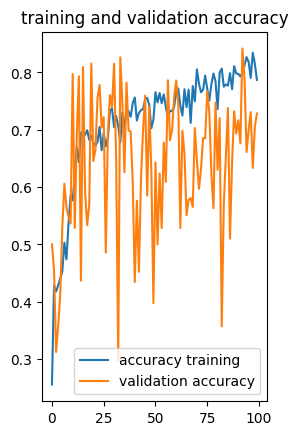

In [22]:
history.params
history.history['accuracy']

acc = history.history['accuracy']
val_acc = history.history['val_accuracy'] 
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='accuracy training')
plt.plot(range(EPOCHS), val_acc, label='validation accuracy')
plt.legend(loc='lower right')
plt.title('training and validation accuracy')

Text(0.5, 1.0, 'training and validation loss')

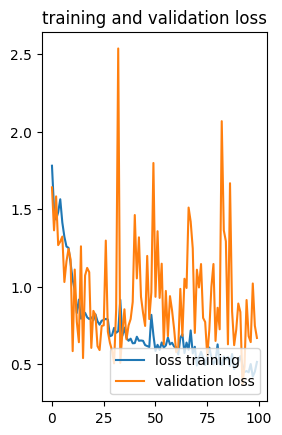

: 

In [23]:
loss = history.history['loss']
val_loss = history.history['val_loss'] 
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), loss, label='loss training')
plt.plot(range(EPOCHS), val_loss, label='validation loss')
plt.legend(loc='lower right')
plt.title('training and validation loss')

In [ ]:
import tensorflow as tf

model = tf.keras.models.load_model("models/model_new5.keras")

for images_batch, labels_batch in test_ds.take(1):    
    for i in range(9):
        plt.subplots_adjust(hspace=1, wspace=1)
        image = images_batch[i]
        label = labels_batch[i]
        
        im_to_show = image[...,0]
        batch_predict = model.predict(images_batch)

        best_predict = np.argmax(batch_predict[i])
        confidence = round(100 * (np.max(batch_predict[i])), 2)

        ax = plt.subplot(3,3, i+ 1)
        plt.imshow(im_to_show)
        plt.axis('off')
        plt.title(f'Label: {id_to_label[label.numpy()]} \n Predict: {id_to_label[best_predict]} \n ({confidence}%)', fontsize=8)
        
    

In [24]:
model.save(f"models/model_new{n_classes}.keras")